[View in Colaboratory](https://colab.research.google.com/github/redpanda-ai/epi_python/blob/master/monte_carlo_simulation_and_reinforcement_learning.ipynb)

In [0]:
# Install Chainer, ChainerRL and CuPy!

!pip -q install gym matplotlib numpy

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
%matplotlib inline

In [0]:
env = gym.make('Blackjack-v0')

In [0]:
state_val = np.zeros((22, 12, 2))
state_count = np.zeros(state_val.shape)
# Hold at values greater than 20
policy = 20

episodes = 100000
for episode in range(episodes):
    complete = False
    s_0 = env.reset()
    G = []
    states = [s_0]
    while complete==False:
        # Implement policy
        if s_0[0] >= policy:
            s_1, reward, complete, _ = env.step(0)
        else:
            s_1, reward, complete, _ = env.step(1)
        
        G.append(reward)
        states.append(s_1)
        
        if complete==True:
            for s_i, s in enumerate(states[:-1]):
                if s[2] == True:
                    s_ace = 1
                else:
                    s_ace = 0
                    
                returns = np.mean(G[s_i:])
    
                # Update values
                state_count[s[0], s[1], s_ace] += 1
                state_val[s[0], s[1], s_ace] = state_val[s[0], s[1], s_ace] + (
                    returns - state_val[s[0], s[1], s_ace]) / state_count[s[0], s[1], s_ace]
            
        s_0 = s_1
        

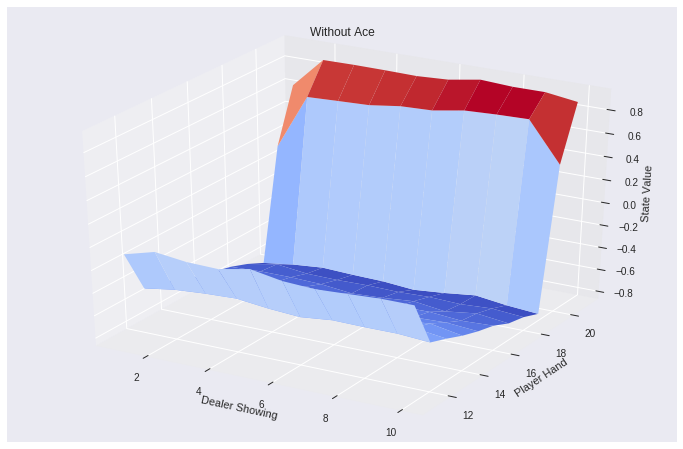

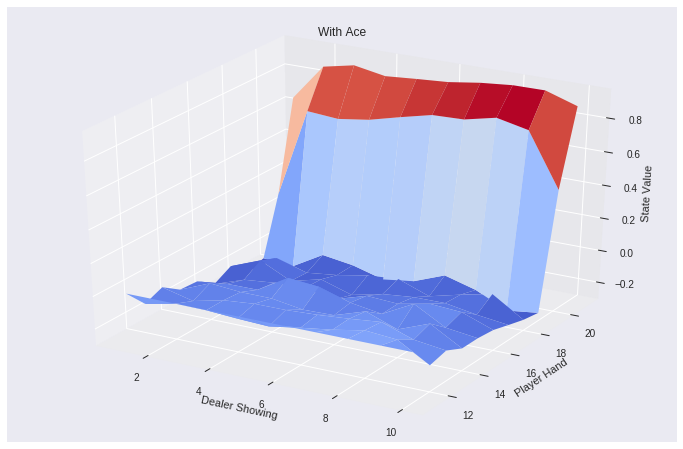

In [9]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
player_range = np.arange(11, 22)
dealer_range = np.arange(1, 11)

X, Y = np.meshgrid(dealer_range, player_range)
Z = state_val[11:22,1:11,0].reshape(X.shape)
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=1,
               rstride=1, cstride=1)
ax.set_title("Without Ace")
ax.set_xlabel("Dealer Showing")
ax.set_ylabel("Player Hand")
ax.set_zlabel("State Value")
plt.show()

# With usable ace
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
player = np.arange(11, 22)
dealer = np.arange(2, 12)

X, Y = np.meshgrid(dealer_range, player_range)
Z = state_val[11:22,1:11,1].reshape(X.shape)
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=1,
               rstride=1, cstride=1)
ax.set_title("With Ace")
ax.set_xlabel("Dealer Showing")
ax.set_ylabel("Player Hand")
ax.set_zlabel("State Value")
plt.show()

In [0]:
np.random.seed(1234)

q = np.zeros((22, 12, 2, 2))
# Initial policy: hold on policies >= 20 (action = 0),
# else hit
q[:20, :, :, 1] = 1
q[20:, :, :, 0] = 1

# Initialize state-action values
state_action_vals = np.zeros((q.shape))
# Initialize counts to 1 so that we don't divide by zero
state_action_counts = np.ones((q.shape))
# Get cards to draw
scores = np.arange(12, 22)
# Function to check for usable ace
# From https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
def usable_ace(player):
    if 1 in player and sum(player) + 10 <= 21:
        return 1
    else:
        return 0

def hand_total(player):
    if usable_ace(player) == 0:
        return sum(player)
    return sum(player) + 10

def get_hand(total, ace):
    if total == 21:
        # Shuffle the order this is shown
        # to ensure dealer hands showing ace
        # are just as probable as showing 10
        # on 21
        p = np.random.rand()
        if p < 0.5:
            return [10, 1], 1
        else:
            return [1, 10], 1
    
    elif ace == 0:
        return [total - 10, 10], 0
    else:
        return [total - 11, 1], 1

n_episodes = 500000
for i in range(n_episodes):
    # Reset environment
    env.reset()
    
    # Randomly initialize starting point
    player_ace = np.random.choice([0, 1])
    player_sum = np.random.choice(scores)
    dealer_ace = np.random.choice([0, 1])
    dealer_sum = np.random.choice(scores)
    
    # Seed the OpenAI Gym environment with the random start
    env.player, player_ace = get_hand(player_sum, player_ace) 
    env.dealer, dealer_ace = get_hand(dealer_sum, dealer_ace)
    
    # Randomize initial action
    action = np.random.choice([0, 1])
    # Log episode history
    state_action_history = []
    complete = False
    while complete == False:
        state_action_history.append([hand_total(env.player), env.dealer[0], 
                                     usable_ace(env.player), action])
        # Take action
        s, reward, complete, _ = env.step(action)
        
        # Select action according to greedy policy
        action = np.argmax(q[np.min([s[0], 21]), s[1], int(s[2]), :])
        
    # Update state-action values after every complete game
    for j in state_action_history:
        state_action_vals[j[0], j[1], j[2], j[3]] += reward
        state_action_counts[j[0], j[1], j[2], j[3]] += 1
        
    q = state_action_vals / state_action_counts


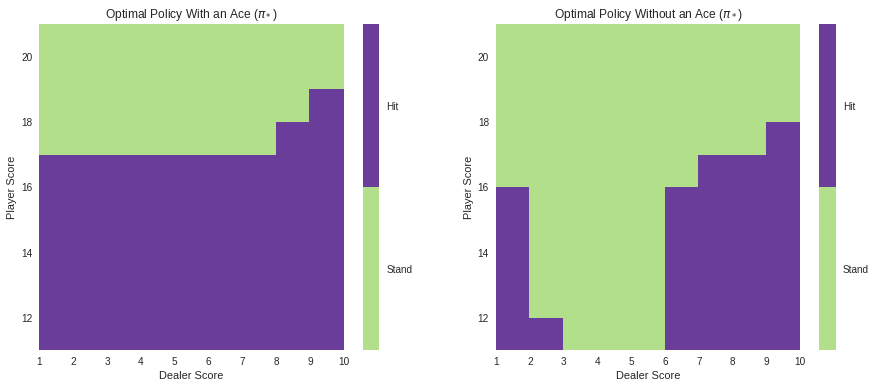

In [11]:
# Split the q-value arrays between arrays with usable aces and those without
q_no_ace = q[player_range[1:], 
             dealer_range.min():dealer_range.max() + 1,
             0, :]
q_usable_ace = q[player_range[1:], 
                 dealer_range.min():dealer_range.max() + 1,
                 1, :]

# Select the maximum valued action to define the policy to follow when 
# you have a usable ace and when you don't
pol_ua_opt = np.zeros((q_usable_ace.shape[0:2]))
pol_na_opt = np.zeros((pol_ua_opt.shape))
for i in range(pol_ua_opt.shape[0]):
    for j in range(pol_ua_opt.shape[1]):
        pol_ua_opt[i, j] = np.argmax(q_usable_ace[i, j])
        pol_na_opt[i, j] = np.argmax(q_no_ace[i, j])
    
# Get colors
cmap = cm.get_cmap("Paired")
colors = list([cmap(0.2), cmap(0.8)])
label = ["Stand", "Hit"]

# Plot results
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.pcolor(dealer_range, player_range, 
           pol_ua_opt, label=label,
           cmap=mpl.colors.ListedColormap(colors))
plt.axis([dealer_range.min(), dealer_range.max(),
          player_range.min(), player_range.max()])
col_bar = plt.colorbar()
col_bar.set_ticks([0.25, 0.75])
col_bar.set_ticklabels(label)
plt.grid()
plt.xlabel("Dealer Score")
plt.ylabel("Player Score")
plt.title("Optimal Policy With an Ace ($\pi_*$)")

plt.subplot(122)
plt.pcolor(dealer_range, player_range, 
           pol_na_opt, label=label,
           cmap=mpl.colors.ListedColormap(colors))
plt.axis([dealer_range.min(), dealer_range.max(),
          player_range.min(), player_range.max()])
col_bar = plt.colorbar()
col_bar.set_ticks([0.25, 0.75])
col_bar.set_ticklabels(label)
plt.grid()
plt.xlabel("Dealer Score")
plt.ylabel("Player Score")
plt.title("Optimal Policy Without an Ace ($\pi_*$)")
plt.show()